## 보편적 처리

학습 이미지 알집
https://drive.google.com/file/d/1AUmFSaUl0D5PHhIrkJnwSmTO2IEWcyjj/view?usp=drive_link

csv파일
https://drive.google.com/file/d/14unQdO1j_LMzqKU-TTkK5MkqOqah6fOb/view?usp=drive_link

In [ ]:
import numpy as np
#이전에 처리해둔 사전과 전처리 라벨링 가져옴, zip파일 형태 다운
%cd /content/
!gdown 1AUmFSaUl0D5PHhIrkJnwSmTO2IEWcyjj --output train.zip

/content
Downloading...
From: https://drive.google.com/uc?id=1AUmFSaUl0D5PHhIrkJnwSmTO2IEWcyjj
To: /content/train.zip
100% 13.6G/13.6G [03:13<00:00, 70.3MB/s]


In [ ]:
#압축해제
import zipfile
path_to_zip_file = '/content/train.zip'
directory_to_extract_to = 'train_img'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [ ]:
!gdown 14unQdO1j_LMzqKU-TTkK5MkqOqah6fOb --output train.csv

Downloading...
From: https://drive.google.com/uc?id=14unQdO1j_LMzqKU-TTkK5MkqOqah6fOb
To: /content/train.csv
100% 159M/159M [00:02<00:00, 67.2MB/s]


파일들 넣음

## 나만 처리

In [1]:
from google.colab import drive

# 구글 드라이브 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#압축해제
import zipfile
path_to_zip_file = '/content/drive/MyDrive/ai경진대회/train_img.zip'
directory_to_extract_to = 'train_img'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [ ]:
import shutil

# 원본 파일 경로
source_file = '/content/drive/MyDrive/ai경진대회/train.csv'

# 복사할 파일 경로
destination_file = '/content/train.csv'

# 파일 복사
shutil.copy(source_file, destination_file)


'/content/train.csv'

## Import

In [2]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 예시만들기용

In [ ]:
import csv
csv_file = "/content/drive/MyDrive/ai경진대회/train.csv"
a = pd.read_csv(csv_file)

In [ ]:
row_index = [0,1,2,3,4,5,6,7,8,9,10]
row_values = a.loc[row_index]
print(row_values)
row_values.to_csv('/content/train_ex.csv', index=False)

        img_id                    img_path  \
0   TRAIN_0000  ./train_img/TRAIN_0000.png   
1   TRAIN_0001  ./train_img/TRAIN_0001.png   
2   TRAIN_0002  ./train_img/TRAIN_0002.png   
3   TRAIN_0003  ./train_img/TRAIN_0003.png   
4   TRAIN_0004  ./train_img/TRAIN_0004.png   
5   TRAIN_0005  ./train_img/TRAIN_0005.png   
6   TRAIN_0006  ./train_img/TRAIN_0006.png   
7   TRAIN_0007  ./train_img/TRAIN_0007.png   
8   TRAIN_0008  ./train_img/TRAIN_0008.png   
9   TRAIN_0009  ./train_img/TRAIN_0009.png   
10  TRAIN_0010  ./train_img/TRAIN_0010.png   

                                             mask_rle  
0   9576 7 10590 17 11614 17 12638 17 13662 17 146...  
1   208402 1 209425 6 210449 10 211473 14 212497 1...  
2   855 34 15654 9 16678 9 16742 8 17702 9 17766 9...  
3   362 6 745 15 798 22 900 25 1385 8 1828 16 1924...  
4   34 27 1058 27 2082 27 3105 27 4129 27 5153 27 ...  
5   9958 29 10982 29 12006 29 13030 29 14054 29 15...  
6   657408 1 658431 2 659455 2 660480 1 661504 1 6...  

In [ ]:
import shutil

# 폴더 복사
source_folder = '/content/drive/MyDrive/ai경진대회/train_ex'
destination_folder = '/content/train_img'

shutil.copytree(source_folder, destination_folder)


'/content/train_img'

## Utils

In [3]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [4]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False, divide=False, af_transform=None, i=0, j=0):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        self.divide = divide
        self.af_transform = None
        self.i = i
        self.j = j

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        #증강 후 분할?, 분할 후 증강?
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # print("\n읽은 정보")
        # print(image.shape)
        # print(mask.shape)
        # print("이제 16분할 들어감!!\n")
        #여기 16분할이 들어가서 처리
        if self.divide:
          result_image = []
          result_mask = []

          stand = 256
          # print(self.i*stand, self.i*stand+stand, self.j*stand, self.j*stand+stand)
          tmp_image = image[:, self.i*stand:self.i*stand+stand, self.j*stand:self.j*stand+stand]

          tmp_mask = mask[self.i*stand:self.i*stand+stand, self.j*stand:self.j*stand+stand]
          # print(idx, i,j,tmp_mask.shape)
          # sub_values = torch.tensor([i*stand, j*stand])
          # tmp_mask = tmp_mask - sub_values[:, None]
          # print(tmp_mask.shape)

          #16분할 중 한장만 쓰면 아래 4줄 주석 의미 없음
          # result_image.append(tmp_image)
          # result_mask.append(tmp_mask)
          # image = np.stack(result_image)
          # mask = np.stack(result_mask)
          image = tmp_image
          mask = tmp_mask

          # print("\n처리끝")
          # print(image.shape)
          # print(mask.shape)

        #분할 후 증강
        if self.af_transform:
            augmented = self.af_transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## Data Loader

## 그냥 256 압축 처리

In [ ]:
transform = A.Compose(
    [
        A.Resize(256, 256),
        # A.Rotate(limit=60),
        ToTensorV2()
    ]

)

dataset = SatelliteDataset(csv_file='/content/train_img/train_ex.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=8)
# for data in dataloader:
#   images, masks = data
#   print(images.shape)
#   print(masks.shape)

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([11, 3, 256, 256])
torch.Size([11, 256, 256])


In [ ]:
for data in dataloader:
  images, masks = data
  print(images.shape)
  print(masks.shape)

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([3, 256, 256])
torch.Size([256, 256])
이제 16분할 들어감!!

torch.Size([11, 3, 256, 256])
torch.Size([11, 256, 256])


[[  0 198]
 [  0 199]
 [  0 200]
 ...
 [255  68]
 [255  69]
 [255  70]]


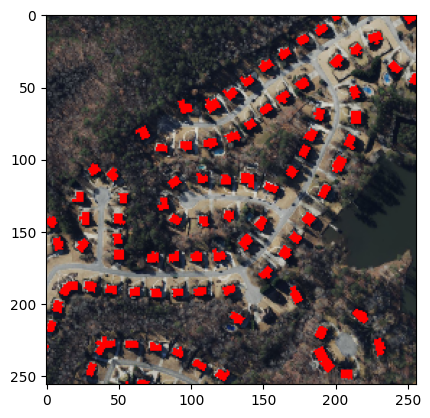

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
idx = 1
# 이미지 텐서를 NumPy 배열로 변환
image_np = images[idx].permute(1, 2, 0).numpy()

# 이미지 출력
plt.imshow(image_np)

# 마스크 정보를 이미지에 추가
mask_np = masks[idx].numpy()
# print(mask_np.shape)
mask_indices = np.where(mask_np != 0)
mask_indices = np.stack(mask_indices, axis=1)  # 2차원 배열로 변환
print(mask_indices)
# 좌표들을 빨간색으로 표시
for coord in mask_indices:
    image_np[coord[0], coord[1]] = [255, 0, 0]  # 빨간색 (R, G, B)

# 이미지 출력
plt.imshow(image_np)
plt.show()


## 16분할 처리

In [ ]:
transform = A.Compose(
    [
        A.Resize(896, 896),
        # A.Rotate(limit=60),
        ToTensorV2()
    ]

)

dataset = SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)
# for data in dataloader:
#   images, masks = data
#   print(images.shape)
#   print(masks.shape)
#너무 큼

In [ ]:
import itertools
subset_dataloader = itertools.islice(dataloader, 1)

# 데이터 확인
for batch in subset_dataloader:
    print("\nAsfsa\n",batch,"\n\n")
    # 데이터 처리 로직
    # 예: 입력 이미지와 레이블에 대한 작업 수행
    images = batch['image']
    mask = batch['mask']

torch.Size([3, 896, 896])
torch.Size([896, 896])
이제 16분할 들어감!!

0 224 0 224torch.Size([3, 896, 896])

torch.Size([896, 896])
0 이제 16분할 들어감!!

00  0 torch.Size([224, 224])
0 224 224 448
0224  00  2241
16 0 0 torch.Size([224, 224]) 
0 224 torch.Size([224, 224])224
 0448 
22416  0 4481 672
0 0 2 torch.Size([224, 224])
0 224  torch.Size([224, 224])
6720  896224
0 0 3 torch.Size([224, 224])
 224448  448672 
16 0 2 0torch.Size([224, 224]) 
2240
 2240  6721  8960
 16torch.Size([224, 224]) 
224 448 0224 3 448 
torch.Size([224, 224])0
 2241  4481  0torch.Size([224, 224]) 
224
224 16448  448 672
0 11  20  torch.Size([224, 224])
torch.Size([224, 224])224
224 448  672 896448 
2240  1448 
16 1 3 torch.Size([224, 224])
448 1 torch.Size([224, 224])
224672  4480  448 224672

160  1 22  torch.Size([224, 224])0 torch.Size([224, 224])
224
448  672448 224  448672
 0896 2 
161 torch.Size([224, 224])
 1448 672 3  torch.Size([224, 224])
448 672 4480 672
0  2224
16 2 0  2 torch.Size([224, 224])torch.Size([224

KeyboardInterrupt: ignored

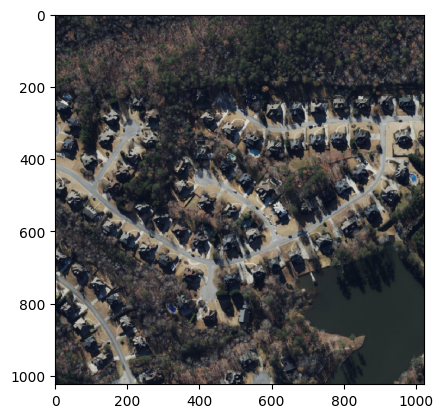

In [ ]:
import matplotlib.pyplot as plt
import cv2
idx = 1
# 이미지 파일 로드
image_path = f'/content/train_img/TRAIN_000{idx}.png'
# image_path = '/content/TEST_00000.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# 이미지 출력
plt.imshow(image)
# plt.axis('off')  # 축 제거
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
idx = 1
# divide_num 값을 변경하면서 16장의 이미지 출력
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flatten()):
    # 이미지 텐서를 NumPy 배열로 변환
    image_np = images[idx][i].permute(1, 2, 0).numpy()

    # 이미지 출력
    ax.imshow(image_np)

    # 마스크 정보를 이미지에 추가
    mask_np = masks[idx][i].numpy()
    mask_indices = np.where(mask_np != 0)
    mask_indices = np.stack(mask_indices, axis=1)  # 2차원 배열로 변환

    # 좌표들을 빨간색으로 표시
    for coord in mask_indices:
        image_np[coord[0], coord[1]] = [255, 0, 0]  # 빨간색 (R, G, B)

    # 이미지 출력
    ax.imshow(image_np)

plt.tight_layout()
plt.show()


## 개별 작업 확인

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


for divide_num in range(16):

  # 이미지 텐서를 NumPy 배열로 변환
  image_np = images[idx][divide_num].permute(1, 2, 0).numpy()

  # 이미지 출력
  plt.imshow(image_np)

  # 마스크 정보를 이미지에 추가
  mask_np = masks[idx][divide_num].numpy()
  # print(mask_np.shape)
  mask_indices = np.where(mask_np != 0)
  mask_indices = np.stack(mask_indices, axis=1)  # 2차원 배열로 변환
  print(mask_indices, mask_indices.shape)
  # 좌표들을 빨간색으로 표시
  for coord in mask_indices:
      image_np[coord[0], coord[1]] = [255, 0, 0]  # 빨간색 (R, G, B)

  # 이미지 출력
  print(idx, divide_num)
  plt.imshow(image_np)
  plt.show()

## Define Model

In [5]:
# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

## Model Train

In [ ]:
# model 초기화
model = UNet().to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training loop
for epoch in range(10):  # 10 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')

  0%|          | 0/447 [00:00<?, ?it/s]

torch.Size([3, 896, 896])
torch.Size([896, 896])
이제 16분할 들어감!!

0 224torch.Size([3, 896, 896]) 
torch.Size([896, 896])0
 이제 16분할 들어감!!
224

00  0224  00  torch.Size([224, 224])224

016  2240  2240  448
torch.Size([224, 224])
00  0 1 torch.Size([224, 224])
224 0224  448224 
16448  0672 
01  torch.Size([224, 224])0
 20  224torch.Size([224, 224]) 
4480 672 
22416  6720  8962
 0torch.Size([224, 224]) 
00  3224  torch.Size([224, 224])672
 224896 
44816  00  2243
 0 torch.Size([224, 224])
1224  0448  torch.Size([224, 224])0
 224224 
44816  2241  0448 
0torch.Size([224, 224])
 1224  1448  torch.Size([224, 224])224
 224448 448
16  4481  6721 torch.Size([224, 224])

224 0 448 1 448 2672 
torch.Size([224, 224])16
 2241  4482  672torch.Size([224, 224]) 896

0224  448 1672 3  torch.Size([224, 224])896

44816  1672  30  224
0torch.Size([224, 224]) 2
 448 0 torch.Size([224, 224])672
448  0672  224224 
44816
0  2 0 torch.Size([224, 224])
448 2672  1224  torch.Size([224, 224])
448448 672
16  2448  1 6

  0%|          | 0/447 [00:42<?, ?it/s]

torch.Size([224, 224])
672 896 448 672

38 3 2 torch.Size([224, 224])
53672 896 672 896
 383 0 3 torch.Size([224, 224]) 

RuntimeError: ignored

##분할 학습

In [ ]:
import shutil
from google.colab import files

transform = A.Compose(
    [
        A.Resize(1024, 1024),
        # A.Resize(896, 896),
        # A.Rotate(limit=60),
        ToTensorV2()
    ]
)

af_transform = A.Compose(
    [
        A.Resize(224, 224),
        # A.Resize(896, 896),
        # A.Rotate(limit=60),
        ToTensorV2()
    ]
)

datasets = [
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=0, j=0),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=0, j=1),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=0, j=2),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=0, j=3),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=1, j=0),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=1, j=1),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=1, j=2),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=1, j=3),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=2, j=0),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=2, j=1),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=2, j=2),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=2, j=3),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=3, j=0),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=3, j=1),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=3, j=2),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=3, j=3)
]

import multiprocessing

num_cores = multiprocessing.cpu_count()

dataloaders = [
    DataLoader(dataset, batch_size=16, shuffle=True, num_workers=num_cores) #순차적으로 한개씩 가져옴
    for dataset in datasets
]

# model 초기화
model = UNet().to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# training loop
start = 0
cnt = 2
for epoch in range(start, start+cnt):  # 10 에폭 동안 학습합니다.
  model.train()
  epoch_loss = 0

  for i, dataloader in enumerate(dataloaders):
      for images, masks in tqdm(dataloader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, masks.unsqueeze(1))
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

      print(f'\n------------\nEpoch {epoch+1} {i}, Loss: {epoch_loss / len(dataloader)}\n------------\n')
  torch.save(model.state_dict(), f'/content/model{epoch}.pth')
  #저장, 다운
  source_file = f'/content/model{epoch}.pth'
  shutil.copy(source_file, f'/content/drive/MyDrive/ai경진대회/model/model{epoch}.pth')
  files.download(f'/content/model{epoch}.pth')

  print(f'\n------------\nEpoch {epoch+1}, Loss: {epoch_loss / len(datasets)}\n------------\n')

100%|██████████| 447/447 [05:13<00:00,  1.43it/s]



------------
Epoch 1 0, Loss: 0.20180984103106278
------------



100%|██████████| 447/447 [05:08<00:00,  1.45it/s]



------------
Epoch 1 1, Loss: 0.4054224518621528
------------



100%|██████████| 447/447 [05:05<00:00,  1.46it/s]



------------
Epoch 1 2, Loss: 0.5888777056529751
------------



100%|██████████| 447/447 [05:09<00:00,  1.44it/s]



------------
Epoch 1 3, Loss: 0.7325122897123597
------------



100%|██████████| 447/447 [05:07<00:00,  1.46it/s]



------------
Epoch 1 4, Loss: 0.8659661483411287
------------



100%|██████████| 447/447 [05:06<00:00,  1.46it/s]



------------
Epoch 1 5, Loss: 0.992925162350038
------------



100%|██████████| 447/447 [05:06<00:00,  1.46it/s]



------------
Epoch 1 6, Loss: 1.1139484527427077
------------



100%|██████████| 447/447 [05:07<00:00,  1.45it/s]



------------
Epoch 1 7, Loss: 1.236222311104304
------------



100%|██████████| 447/447 [05:06<00:00,  1.46it/s]



------------
Epoch 1 8, Loss: 1.348511699453763
------------



100%|██████████| 447/447 [05:25<00:00,  1.37it/s]



------------
Epoch 1 9, Loss: 1.4569624715403422
------------



100%|██████████| 447/447 [05:08<00:00,  1.45it/s]



------------
Epoch 1 10, Loss: 1.55962608487114
------------



100%|██████████| 447/447 [05:07<00:00,  1.45it/s]



------------
Epoch 1 11, Loss: 1.6687602858898758
------------



100%|██████████| 447/447 [05:09<00:00,  1.45it/s]



------------
Epoch 1 12, Loss: 1.7690620023165506
------------



100%|██████████| 447/447 [05:08<00:00,  1.45it/s]



------------
Epoch 1 13, Loss: 1.8737168119641092
------------



100%|██████████| 447/447 [05:06<00:00,  1.46it/s]



------------
Epoch 1 14, Loss: 1.9966757651210099
------------



100%|██████████| 447/447 [05:07<00:00,  1.45it/s]



------------
Epoch 1 15, Loss: 2.098610714886346
------------



FileNotFoundError: ignored

In [ ]:
start = 6 #매번 수정
cnt = 14 #한번에 돌릴 epoch수
# 저장된 모델 파일 경로
path = f'/content/drive/MyDrive/ai경진대회/model/model{start-1}.pth'
print(path)
# 모델 로드
model = UNet()
model.load_state_dict(torch.load(path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# #cpu로 저장시
# # 모델 인스턴스 생성
# model = UNet()
# # 저장된 상태 사전 로드
# model.load_state_dict(torch.load(path, map_location=torch.device("cpu")))
# # 모델을 원하는 디바이스로 이동
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

import shutil
from google.colab import files

transform = A.Compose(
    [
        A.Resize(1024, 1024),
        # A.Resize(896, 896),
        # A.Rotate(limit=60),
        ToTensorV2()
    ]
)

af_transform = A.Compose(
    [
        A.Resize(224, 224),
        # A.Resize(896, 896),
        # A.Rotate(limit=60),
        ToTensorV2()
    ]
)

datasets = [
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=0, j=0),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=0, j=1),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=0, j=2),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=0, j=3),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=1, j=0),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=1, j=1),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=1, j=2),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=1, j=3),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=2, j=0),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=2, j=1),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=2, j=2),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=2, j=3),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=3, j=0),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=3, j=1),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=3, j=2),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=3, j=3)
]

import multiprocessing

num_cores = multiprocessing.cpu_count()

dataloaders = [
    DataLoader(dataset, batch_size=16, shuffle=True, num_workers=num_cores) #순차적으로 한개씩 가져옴
    for dataset in datasets
]

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training loop
for epoch in range(start, start+cnt):  # 10 에폭 동안 학습합니다.
  model.train()
  epoch_loss = 0

  for i, dataloader in enumerate(dataloaders):
      for images, masks in tqdm(dataloader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, masks.unsqueeze(1))
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

      print(f'\n------------\nEpoch {epoch+1} {i}, Loss: {epoch_loss / len(dataloader)}\n------------\n')

  #gpu상태 저장
  torch.save(model.state_dict(), f'/content/model{epoch}.pth')

  # #cpu로 옮겨서 저장
  # model_cpu = model.to("cpu")
  # # 모델의 상태 사전을 저장
  # torch.save(model_cpu.state_dict(), path)

  #저장, 다운
  source_file = f'/content/model{epoch}.pth'
  shutil.copy(source_file, f'/content/drive/MyDrive/ai경진대회/model/model{epoch}.pth')
  # files.download(f'/content/model{epoch}.pth')

  print(f'\n------------\nEpoch {epoch+1}, Loss: {epoch_loss / len(datasets)}\n------------\n')

/content/drive/MyDrive/ai경진대회/model/model5.pth


100%|██████████| 447/447 [05:13<00:00,  1.43it/s]



------------
Epoch 7 0, Loss: 0.07166629100439266
------------



100%|██████████| 447/447 [05:15<00:00,  1.41it/s]



------------
Epoch 7 1, Loss: 0.138000439427443
------------



100%|██████████| 447/447 [05:15<00:00,  1.41it/s]



------------
Epoch 7 2, Loss: 0.22893119920086807
------------



100%|██████████| 447/447 [05:14<00:00,  1.42it/s]



------------
Epoch 7 3, Loss: 0.30797857802436257
------------



100%|██████████| 447/447 [05:16<00:00,  1.41it/s]



------------
Epoch 7 4, Loss: 0.38169462665065423
------------



100%|██████████| 447/447 [05:15<00:00,  1.42it/s]



------------
Epoch 7 5, Loss: 0.4547529374468047
------------



100%|██████████| 447/447 [05:15<00:00,  1.42it/s]



------------
Epoch 7 6, Loss: 0.5295910492364392
------------



100%|██████████| 447/447 [05:17<00:00,  1.41it/s]



------------
Epoch 7 7, Loss: 0.6003167323509785
------------



100%|██████████| 447/447 [05:19<00:00,  1.40it/s]



------------
Epoch 7 8, Loss: 0.6707117797502669
------------



100%|██████████| 447/447 [05:18<00:00,  1.40it/s]



------------
Epoch 7 9, Loss: 0.7389994967495501
------------



100%|██████████| 447/447 [05:16<00:00,  1.41it/s]



------------
Epoch 7 10, Loss: 0.8086767046268555
------------



100%|██████████| 447/447 [05:16<00:00,  1.41it/s]



------------
Epoch 7 11, Loss: 0.8806868031645981
------------



100%|██████████| 447/447 [05:16<00:00,  1.41it/s]



------------
Epoch 7 12, Loss: 0.9491962609391751
------------



100%|██████████| 447/447 [05:15<00:00,  1.42it/s]



------------
Epoch 7 13, Loss: 1.017835609093975
------------



100%|██████████| 447/447 [05:15<00:00,  1.42it/s]



------------
Epoch 7 14, Loss: 1.0872798325448094
------------



100%|██████████| 447/447 [05:16<00:00,  1.41it/s]



------------
Epoch 7 15, Loss: 1.1545782100067576
------------


------------
Epoch 7, Loss: 32.25602874206379
------------



100%|██████████| 447/447 [05:13<00:00,  1.43it/s]



------------
Epoch 8 0, Loss: 0.06710718339621621
------------



100%|██████████| 447/447 [05:12<00:00,  1.43it/s]



------------
Epoch 8 1, Loss: 0.13270099222726736
------------



100%|██████████| 447/447 [05:09<00:00,  1.44it/s]



------------
Epoch 8 2, Loss: 0.19903192358712354
------------



100%|██████████| 447/447 [05:11<00:00,  1.43it/s]



------------
Epoch 8 3, Loss: 0.26798761093476475
------------



100%|██████████| 447/447 [05:09<00:00,  1.44it/s]



------------
Epoch 8 4, Loss: 0.3358676565906879
------------



100%|██████████| 447/447 [05:10<00:00,  1.44it/s]



------------
Epoch 8 5, Loss: 0.4035430194922542
------------



100%|██████████| 447/447 [05:13<00:00,  1.43it/s]



------------
Epoch 8 6, Loss: 0.47199851854952257
------------



100%|██████████| 447/447 [05:14<00:00,  1.42it/s]



------------
Epoch 8 7, Loss: 0.539299955320705
------------



100%|██████████| 447/447 [05:11<00:00,  1.43it/s]



------------
Epoch 8 8, Loss: 0.6078570189550352
------------



100%|██████████| 447/447 [05:08<00:00,  1.45it/s]



------------
Epoch 8 9, Loss: 0.6759007688595078
------------



100%|██████████| 447/447 [05:06<00:00,  1.46it/s]



------------
Epoch 8 10, Loss: 0.7424005816296843
------------



100%|██████████| 447/447 [05:09<00:00,  1.44it/s]



------------
Epoch 8 11, Loss: 0.8081486220044445
------------



100%|██████████| 447/447 [05:07<00:00,  1.46it/s]



------------
Epoch 8 12, Loss: 0.8745965540775783
------------



100%|██████████| 447/447 [05:11<00:00,  1.44it/s]



------------
Epoch 8 13, Loss: 0.9417075082759729
------------



100%|██████████| 447/447 [05:09<00:00,  1.44it/s]



------------
Epoch 8 14, Loss: 1.010127692493783
------------



100%|██████████| 447/447 [05:09<00:00,  1.44it/s]



------------
Epoch 8 15, Loss: 1.0757412732947593
------------


------------
Epoch 8, Loss: 30.053521822672337
------------



100%|██████████| 447/447 [05:08<00:00,  1.45it/s]



------------
Epoch 9 0, Loss: 0.06496786067816501
------------



100%|██████████| 447/447 [05:09<00:00,  1.45it/s]



------------
Epoch 9 1, Loss: 0.12886648280108534
------------



100%|██████████| 447/447 [05:12<00:00,  1.43it/s]



------------
Epoch 9 2, Loss: 0.19346153491512108
------------



100%|██████████| 447/447 [05:10<00:00,  1.44it/s]



------------
Epoch 9 3, Loss: 0.26102174000535366
------------



100%|██████████| 447/447 [05:08<00:00,  1.45it/s]



------------
Epoch 9 4, Loss: 0.3249362481953847
------------



100%|██████████| 447/447 [05:08<00:00,  1.45it/s]



------------
Epoch 9 5, Loss: 0.3889292596195568
------------



100%|██████████| 447/447 [05:10<00:00,  1.44it/s]



------------
Epoch 9 6, Loss: 0.4553412153808529
------------



100%|██████████| 447/447 [05:10<00:00,  1.44it/s]



------------
Epoch 9 7, Loss: 0.5199464453838483
------------



 98%|█████████▊| 438/447 [05:07<00:05,  1.57it/s]

##작업중

In [ ]:
start = 8 #매번 수정
cnt = 3 #한번에 돌릴 epoch수
# 저장된 모델 파일 경로
path = f'/content/drive/MyDrive/ai경진대회/model/model{start-1}.pth'
print(path)
# 모델 로드
model = UNet()
model.load_state_dict(torch.load(path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# #cpu로 저장시
# # 모델 인스턴스 생성
# model = UNet()
# # 저장된 상태 사전 로드
# model.load_state_dict(torch.load(path, map_location=torch.device("cpu")))
# # 모델을 원하는 디바이스로 이동
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

import shutil
from google.colab import files

transform = A.Compose(
    [
        A.Resize(1024, 1024),
        # A.Resize(896, 896),
        # A.Rotate(limit=60),
        ToTensorV2()
    ]
)

af_transform = A.Compose(
    [
        A.Resize(224, 224),
        # A.Resize(896, 896),
        # A.Rotate(limit=60),
        ToTensorV2()
    ]
)

datasets = [
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=0, j=0),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=0, j=1),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=0, j=2),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=0, j=3),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=1, j=0),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=1, j=1),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=1, j=2),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=1, j=3),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=2, j=0),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=2, j=1),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=2, j=2),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=2, j=3),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=3, j=0),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=3, j=1),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=3, j=2),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, divide = True, af_transform=af_transform, i=3, j=3)
]

현재 16배인데 최소 3배 이상


import multiprocessing

num_cores = multiprocessing.cpu_count()

dataloaders = [
    DataLoader(dataset, batch_size=16, shuffle=True, num_workers=num_cores) #순차적으로 한개씩 가져옴
    for dataset in datasets
]

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training loop
for epoch in range(start, start+cnt):  # 10 에폭 동안 학습합니다.
  model.train()
  epoch_loss = 0

  for i, dataloader in enumerate(dataloaders):
      for images, masks in tqdm(dataloader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, masks.unsqueeze(1))
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

      print(f'\n------------\nEpoch {epoch+1} {i}, Loss: {epoch_loss / len(dataloader)}\n------------\n')

  #gpu상태 저장
  torch.save(model.state_dict(), f'/content/model{epoch}.pth')

  # #cpu로 옮겨서 저장
  # model_cpu = model.to("cpu")
  # # 모델의 상태 사전을 저장
  # torch.save(model_cpu.state_dict(), path)

  #저장, 다운
  source_file = f'/content/model{epoch}.pth'
  shutil.copy(source_file, f'/content/drive/MyDrive/ai경진대회/model/model{epoch}.pth')
  # files.download(f'/content/model{epoch}.pth')

  print(f'\n------------\nEpoch {epoch+1}, Loss: {epoch_loss / len(datasets)}\n------------\n')

/content/drive/MyDrive/ai경진대회/model/model7.pth


100%|██████████| 447/447 [05:13<00:00,  1.42it/s]



------------
Epoch 9 0, Loss: 0.06916723637456196
------------



100%|██████████| 447/447 [05:08<00:00,  1.45it/s]



------------
Epoch 9 1, Loss: 0.13736434712155954
------------



100%|██████████| 447/447 [05:11<00:00,  1.44it/s]



------------
Epoch 9 2, Loss: 0.20220075512692431
------------



100%|██████████| 447/447 [05:12<00:00,  1.43it/s]



------------
Epoch 9 3, Loss: 0.26730157539115124
------------



100%|██████████| 447/447 [05:11<00:00,  1.44it/s]



------------
Epoch 9 4, Loss: 0.33282103220321724
------------



100%|██████████| 447/447 [05:08<00:00,  1.45it/s]



------------
Epoch 9 5, Loss: 0.3971465289492735
------------



100%|██████████| 447/447 [05:12<00:00,  1.43it/s]



------------
Epoch 9 6, Loss: 0.4628721553065566
------------



100%|██████████| 447/447 [05:15<00:00,  1.42it/s]



------------
Epoch 9 7, Loss: 0.5274272246048755
------------



100%|██████████| 447/447 [05:14<00:00,  1.42it/s]



------------
Epoch 9 8, Loss: 0.5920910165088888
------------



100%|██████████| 447/447 [05:14<00:00,  1.42it/s]



------------
Epoch 9 9, Loss: 0.6558185341524198
------------



100%|██████████| 447/447 [05:13<00:00,  1.42it/s]



------------
Epoch 9 10, Loss: 0.7207620858571073
------------



100%|██████████| 447/447 [05:13<00:00,  1.43it/s]



------------
Epoch 9 11, Loss: 0.7853992656581688
------------



100%|██████████| 447/447 [05:15<00:00,  1.42it/s]



------------
Epoch 9 12, Loss: 0.8515786237918858
------------



100%|██████████| 447/447 [05:15<00:00,  1.42it/s]



------------
Epoch 9 13, Loss: 0.9191643009670663
------------



100%|██████████| 447/447 [05:15<00:00,  1.42it/s]



------------
Epoch 9 14, Loss: 0.9847952131727831
------------



100%|██████████| 447/447 [05:13<00:00,  1.43it/s]



------------
Epoch 9 15, Loss: 1.0483839386424063
------------


------------
Epoch 9, Loss: 29.289226285822224
------------



100%|██████████| 447/447 [05:15<00:00,  1.42it/s]



------------
Epoch 10 0, Loss: 0.06382238147342766
------------



100%|██████████| 447/447 [05:15<00:00,  1.42it/s]



------------
Epoch 10 1, Loss: 0.12539250514067926
------------



100%|██████████| 447/447 [05:15<00:00,  1.42it/s]



------------
Epoch 10 2, Loss: 0.19176226232192528
------------



100%|██████████| 447/447 [05:14<00:00,  1.42it/s]



------------
Epoch 10 3, Loss: 0.25680036075679913
------------



100%|██████████| 447/447 [05:13<00:00,  1.42it/s]



------------
Epoch 10 4, Loss: 0.3202687275473037
------------



100%|██████████| 447/447 [05:14<00:00,  1.42it/s]



------------
Epoch 10 5, Loss: 0.3828799124490428
------------



100%|██████████| 447/447 [05:15<00:00,  1.42it/s]



------------
Epoch 10 6, Loss: 0.44851601284238984
------------



100%|██████████| 447/447 [05:11<00:00,  1.43it/s]



------------
Epoch 10 7, Loss: 0.5124266163031393
------------



100%|██████████| 447/447 [05:11<00:00,  1.43it/s]



------------
Epoch 10 8, Loss: 0.574441159085706
------------



100%|██████████| 447/447 [05:09<00:00,  1.44it/s]



------------
Epoch 10 9, Loss: 0.6374189148738281
------------



100%|██████████| 447/447 [05:10<00:00,  1.44it/s]



------------
Epoch 10 10, Loss: 0.6996245439512284
------------



100%|██████████| 447/447 [05:11<00:00,  1.44it/s]



------------
Epoch 10 11, Loss: 0.7643603221440408
------------



100%|██████████| 447/447 [05:11<00:00,  1.44it/s]



------------
Epoch 10 12, Loss: 0.8297922315880223
------------



100%|██████████| 447/447 [05:12<00:00,  1.43it/s]



------------
Epoch 10 13, Loss: 0.8926967352928731
------------



100%|██████████| 447/447 [05:09<00:00,  1.45it/s]



------------
Epoch 10 14, Loss: 0.9580314761023527
------------



100%|██████████| 447/447 [05:06<00:00,  1.46it/s]



------------
Epoch 10 15, Loss: 1.021104642963016
------------


------------
Epoch 10, Loss: 28.52711096277926
------------



100%|██████████| 447/447 [05:06<00:00,  1.46it/s]



------------
Epoch 11 0, Loss: 0.06247168438513274
------------



100%|██████████| 447/447 [05:06<00:00,  1.46it/s]



------------
Epoch 11 1, Loss: 0.12337902342063069
------------



100%|██████████| 447/447 [05:07<00:00,  1.45it/s]



------------
Epoch 11 2, Loss: 0.18474213501867698
------------



100%|██████████| 447/447 [05:07<00:00,  1.45it/s]



------------
Epoch 11 3, Loss: 0.24770567190293766
------------



100%|██████████| 447/447 [05:11<00:00,  1.44it/s]



------------
Epoch 11 4, Loss: 0.31275542187910754
------------



100%|██████████| 447/447 [05:17<00:00,  1.41it/s]



------------
Epoch 11 5, Loss: 0.374652554024786
------------



100%|██████████| 447/447 [05:17<00:00,  1.41it/s]



------------
Epoch 11 6, Loss: 0.43738841697556996
------------



100%|██████████| 447/447 [05:13<00:00,  1.43it/s]



------------
Epoch 11 7, Loss: 0.49925823758045834
------------



100%|██████████| 447/447 [05:13<00:00,  1.43it/s]



------------
Epoch 11 8, Loss: 0.5608622608685521
------------



100%|██████████| 447/447 [05:11<00:00,  1.43it/s]



------------
Epoch 11 9, Loss: 0.6219402610530589
------------



100%|██████████| 447/447 [05:11<00:00,  1.43it/s]



------------
Epoch 11 10, Loss: 0.6830437280596036
------------



100%|██████████| 447/447 [05:08<00:00,  1.45it/s]



------------
Epoch 11 11, Loss: 0.7473088094560425
------------



100%|██████████| 447/447 [05:13<00:00,  1.43it/s]



------------
Epoch 11 12, Loss: 0.8090486530572909
------------



100%|██████████| 447/447 [05:12<00:00,  1.43it/s]



------------
Epoch 11 13, Loss: 0.8706496289954156
------------



100%|██████████| 447/447 [05:12<00:00,  1.43it/s]



------------
Epoch 11 14, Loss: 0.9338088397611708
------------



100%|██████████| 447/447 [05:09<00:00,  1.44it/s]



------------
Epoch 11 15, Loss: 0.9941687080675791
------------


------------
Epoch 11, Loss: 27.77458828163799
------------



## Inference

In [6]:
import numpy as np
#이전에 처리해둔 사전과 전처리 라벨링 가져옴, zip파일 형태 다운
%cd /content/
!gdown 1_yxd4MFtXTrzlwIIybvKB5_BDIJ7DBo7 --output test.zip

/content
Downloading...
From: https://drive.google.com/uc?id=1_yxd4MFtXTrzlwIIybvKB5_BDIJ7DBo7
To: /content/test.zip
100% 5.53G/5.53G [01:23<00:00, 66.6MB/s]


In [7]:
#압축해제
import zipfile
path_to_zip_file = '/content/test.zip'
directory_to_extract_to = 'test_img'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [8]:
!gdown 1V3mMFTwqB-7AJ7UbMEJt_sBDqT2yqg_W --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1V3mMFTwqB-7AJ7UbMEJt_sBDqT2yqg_W
To: /content/test.csv
100% 2.24M/2.24M [00:00<00:00, 155MB/s]


In [9]:
!gdown 1OUYeemW6ebbdusQbrmfr_YxHFTfyP19K --output sample_submission.csv

Downloading...
From: https://drive.google.com/uc?id=1OUYeemW6ebbdusQbrmfr_YxHFTfyP19K
To: /content/sample_submission.csv
100% 849k/849k [00:00<00:00, 163MB/s]


In [10]:

transform = A.Compose(
    [
        A.Resize(224, 224),
        # A.Resize(896, 896),
        # A.Rotate(limit=60),
        ToTensorV2()
    ]
)

test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [11]:
start = 10
# 저장된 모델 파일 경로
path = f'/content/drive/MyDrive/ai경진대회/model/model{start-1}.pth'
print(path)
# 모델 로드
model = UNet()
model.load_state_dict(torch.load(path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/content/drive/MyDrive/ai경진대회/model/model9.pth


UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [20]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

100%|██████████| 3790/3790 [11:07<00:00,  5.68it/s]


## Submission

In [21]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

In [22]:
submit.to_csv('./submit.csv', index=False)

In [ ]:
from google.colab import files
files.download('/content/submit2.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
import shutil
source_file = f'/content/submit.csv'
shutil.copy(source_file, f'/content/drive/MyDrive/ai경진대회/model/submit-0.35.csv')

'/content/drive/MyDrive/ai경진대회/model/submit-0.35.csv'